<a href="https://colab.research.google.com/github/mepix/CropWeedClassification/blob/main/CropCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
# Import Libaries
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
import time
import os
import copy
from torch.utils.data.sampler import WeightedRandomSampler
import seaborn as sn
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

In [2]:
# Connect to Google Drive
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Trial 1

batch_size = 32
epochs = 100
eta = 0.1
imgDim = 224
step_size = 7
gamma = 0.01
optimizer_type = "Adam"
scheduler_type = "StepLR"
do_three_classes = True
use_train_test_split = False # Should Use Weighted Random Sampling for Better Performance

Poor Results

## Trial 2

batch_size = 32
epochs = 100
eta = 0.01
imgDim = 224
step_size = 7
gamma = 0.01

slightly better

In [3]:
# Set the Batch Size & Hyperparameters
batch_size = 32
epochs = 100
eta = 0.01
imgDim = 224
step_size = 25
gamma = 0.01
optimizer_type = "Adam"
scheduler_type = "StepLR"
do_three_classes = False
use_train_test_split = False # Should Use Weighted Random Sampling for Better Performance

# Record Keeping
do_save_model = True
path_to_saved_model = '/content/gdrive/MyDrive/EE244/output/'

# Use the function train_test_split to divide data that is in one folder
if use_train_test_split:
  do_three_classes = False
  path_to_data = '/content/gdrive/MyDrive/EE244/data/Split-Classes'

# use the data that is already presplit into folders manually
if do_three_classes:
  path_to_data_train = "/content/gdrive/MyDrive/EE244/data/Split-Classes-X3/Data-Train"
  path_to_data_test = "/content/gdrive/MyDrive/EE244/data/Split-Classes-X3/Data-Test"
  labels = ["Crop","Weed_Big","Weed_Small"]
else: #do the full dataset
  path_to_data_train = "/content/gdrive/MyDrive/EE244/data/Data-Train"
  path_to_data_test = "/content/gdrive/MyDrive/EE244/data/Data-Test"
  labels = ["Crop","Weed1","Weed2","Weed3","Weed4","Weed5","Weed6","Weed7","Weed8","Weed9"]

# Normalize to Zero Mean
transform = transforms.Compose(
    [
     transforms.Resize([224,224]),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) #MEAN & STDDEV for ResNet
    ])

# Check GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Compute samples weight (each sample should get its own weight)
def getSampleWeights(dataset):
  target = torch.Tensor(dataset.targets).type(torch.LongTensor)
  print("Target Labels:",target)
  class_sample_count = torch.tensor(
      [(target == t).sum() for t in torch.unique(target, sorted=True)])
  print("Sample Count:",class_sample_count)
  weight = 1. / class_sample_count.float()
  print("Weights:",weight)
  samples_weight = torch.tensor([weight[t] for t in target])
  print("Samples Weights:",samples_weight)
  sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
  return sampler


if use_train_test_split:
  # Load the Images from the Image Folder
  dataset = datasets.ImageFolder(root=path_to_data, transform=transform)

  # Split into Train and Test Set
  pct_test = 0.25
  train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=pct_test)
  data = {}
  data['train'] = Subset(dataset,train_idx)
  data['test'] = Subset(dataset,test_idx)

  # Build the Train and Test DataLoaders
  dataloaders = {x:DataLoader(data[x],batch_size, num_workers=2,shuffle=True) for x in ['train','test']}

else:
  # Get Train & Test Set (With Weighted Random Sampling)
  data = {}
  data['train'] = datasets.ImageFolder(root=path_to_data_train, transform=transform)
  data['test'] = datasets.ImageFolder(root=path_to_data_test, transform=transform)


  sampler = {}
  sampler['train'] = getSampleWeights(data['train'])
  sampler['test'] = None

  # Build the Train and Test DataLoaders
  dataloaders = {x:DataLoader(data[x],batch_size, num_workers=2,sampler=sampler[x]) for x in ['train','test']}



# def multi2tri(data,verbose=False):
#   """Turns a MultiClass Dataset into a 3-Class Dataset"""
    #https://discuss.pytorch.org/t/change-labels-in-data-loader/36823/13
#   if verbose: print("Input Target Classes:",np.unique(data.targets))
#   data.targets = torch.tensor(data.targets).type(torch.LongTensor)
#   data.targets[data.targets > 2] = 2
#   if verbose: print("Output Target Classes:",np.unique(data.targets))
#   return data

#   for k in range(10):
#     if verbose: print(data.targets[data.targets == k])
#     data.targets[data.targets == k] = 2
#   # data.targets[data.targets > 2] = 2

#   return data


x,y = next(iter(dataloaders['train']))

# Rebundle Datasets
dataset_sizes = {
    'train':len(data['train']),
    'test':len(data['test'])}

# Check Sizes
print(x.shape, y.shape)
# print("Original Dataset",len(dataset))
print("Training Dataset",len(data['train']))
print("Testing Dataset",len(data['test']))
# for i, (x, y) in enumerate(dataloaders['train']):
#     print("batch index {}, 0/1: {}/{}".format(
#         i, (y == 0).sum(), (y == 1).sum()))


Target Labels: tensor([0, 0, 0,  ..., 9, 9, 9])
Sample Count: tensor([ 799, 1591,    8,  301,   28,  113,   61,   14,   46,    5])
Weights: tensor([0.0013, 0.0006, 0.1250, 0.0033, 0.0357, 0.0088, 0.0164, 0.0714, 0.0217,
        0.2000])
Samples Weights: tensor([0.0013, 0.0013, 0.0013,  ..., 0.2000, 0.2000, 0.2000])
torch.Size([32, 3, 224, 224]) torch.Size([32])
Training Dataset 2966
Testing Dataset 1032


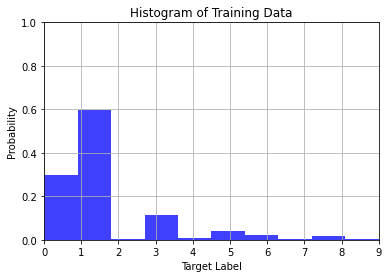

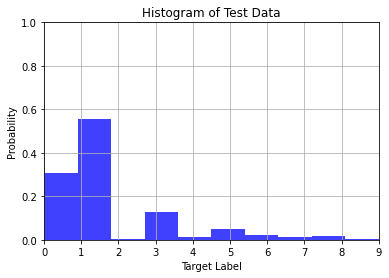

In [4]:
def plotHistogram(data,number_bins,title=None):
  """Plots the Histogram of the Given Dataset"""
  # https://matplotlib.org/stable/gallery/pyplots/pyplot_text.html#sphx-glr-gallery-pyplots-pyplot-text-py

  x = data.targets
  n, bins, patches = plt.hist(x, number_bins,density=True, facecolor='b', alpha=0.75)

  plt.xlabel('Target Label')
  plt.ylabel('Probability')
  plt.title(title)
  plt.xlim(0, number_bins-1)
  plt.ylim(0, 1)
  plt.grid(True)
  plt.show()

plotHistogram(data["train"],len(labels),"Histogram of Training Data")
plotHistogram(data["test"],len(labels),"Histogram of Test Data")

In [5]:
# Determine the MEAN and STD Manually and then re-run block
# mean = 0.0
# std = 0.0
# nb_samples = 0.0
# for data in dataloaders['train']: #assume same for test and train data 
#     batch_samples = data.size(0)
#     data = data.view(batch_samples, data.size(1), -1)
#     mean += data.mean(2).sum(0)
#     std += data.std(2).sum(0)
#     nb_samples += batch_samples

# mean /= nb_samples
# std /= nb_samples

# print(mean)
# print(std)
#print(dataset.data.shape)
# print(data['train'].mean(axis=(0,1,2))/255)
# print(trainset.data.std(axis=(0,1,2))/255)
#[0.49139968 0.48215841 0.44653091]
#[0.24703223 0.24348513 0.26158784]

# https://discuss.pytorch.org/t/computing-the-mean-and-std-of-dataset/34949/15
# https://pytorch.org/docs/stable/generated/torch.nn.functional.normalize.html
# https://discuss.pytorch.org/t/about-normalization-using-pre-trained-vgg16-networks/23560/6?u=ptrblck

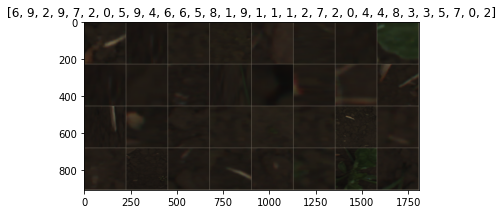

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # Add back the mean and std for visualization
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# INPUTS: a vector of images [batch_size,num_channels,height,width]
# CLASSES: an array containing the index of the appropriate class_names

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Visualize a sample set of images to verify we imported everything OK
imshow(out, title=[int(classes[x]) for x in range(batch_size)])

In [7]:
def getNetworkModel(model_type="ResNet",step_size=7,gamma=0.1,optimizer_type=None,scheduler_type="StepLR"):
  """Create the parameters necessary for the RESNET model"""
  # Load in the ResNet Model
  if model_type == "ResNet":
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
  else:
    return None #TODO: Try other Models

  # Determine the Number of Features
  # num_ftrs = modelResNet.fc.in_features

  # Size of each output sample is generalized to nn.Linear(num_ftrs, len(class_names))
  # model.fc = nn.Linear(imgDim*imgDim, len(class_names))

  # Push to GPU
  model = model.to(device)

  # Set the Loss Criterion
  criterion = nn.CrossEntropyLoss()

  # Observe that all parameters are being optimized
  if optimizer_type == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=eta) #https://pytorch.org/docs/master/generated/torch.optim.Adam.html
  else:
    optimizer = None

  # Decay LR by a factor of 0.1 every 7 epochs TOO AGGRESSIVE FOR RESNET: 0.01  epoch80 0.001 epoch120 0.0001 (Mayve start at 60 or 40 for smaller data set)
  if scheduler_type == "StepLR":
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
  else:
    scheduler = None

  return model, criterion, optimizer, scheduler

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Store training values in lists
    training_acc = []
    training_loss = []
    validation_acc = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels.long())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Store Performance in Arrays
            if phase == 'train':
              training_loss.append(epoch_loss)
              training_acc.append(epoch_acc.item())
            else: # must be validation
              validation_acc.append(epoch_acc.item())


            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, training_acc, training_loss, validation_acc



In [9]:
def plotResults(training_loss,training_acc,test_acc,titleStr=""):
  """Plots the training_loss, training_acc, and test_acc with the provided title"""
  # Create Figure
  plt.figure(figsize=(15,3))
  plt.suptitle(titleStr, fontsize=15)

  # Training Loss Plot
  plt.subplot(131)
  plt.plot(training_loss)
  plt.xlabel('Epoch', fontsize=10)
  plt.ylabel('Training Loss', fontsize=10)
  plt.grid(True)

  # Training Accuracy Plot
  plt.subplot(132)
  plt.plot(training_acc)
  plt.xlabel('Epoch', fontsize=10)
  plt.ylabel('Training Accuracy', fontsize=10)
  plt.grid(True)

  # Test Accuracy Plot
  plt.subplot(133)
  plt.plot(test_acc)
  plt.xlabel('Epoch', fontsize=10)
  plt.ylabel('Test Accuracy', fontsize=10)
  plt.grid(True)

  # Adjust Dimensions
  plt.subplots_adjust(wspace=.5)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip


Epoch 0/99
----------
train Loss: 2.5318 Acc: 0.1362
test Loss: 9.9906 Acc: 0.0019

Epoch 1/99
----------
train Loss: 2.1144 Acc: 0.2124
test Loss: 1.9809 Acc: 0.3537

Epoch 2/99
----------
train Loss: 1.8321 Acc: 0.3152
test Loss: 2.8657 Acc: 0.2665

Epoch 3/99
----------
train Loss: 1.4790 Acc: 0.4434
test Loss: 4.3379 Acc: 0.0155

Epoch 4/99
----------
train Loss: 1.2689 Acc: 0.5185
test Loss: 3.0447 Acc: 0.2655

Epoch 5/99
----------
train Loss: 1.0031 Acc: 0.6183
test Loss: 3.2724 Acc: 0.0853

Epoch 6/99
----------
train Loss: 0.8173 Acc: 0.6993
test Loss: 3.6181 Acc: 0.1570

Epoch 7/99
----------
train Loss: 0.7198 Acc: 0.7218
test Loss: 2.0354 Acc: 0.1298

Epoch 8/99
----------
train Loss: 0.6085 Acc: 0.7647
test Loss: 2.0339 Acc: 0.1967

Epoch 9/99
----------
train Loss: 0.4556 Acc: 0.8237
test Loss: 2.2758 Acc: 0.2103

Epoch 10/99
----------
train Loss: 0.4344 Acc: 0.8270
test Loss: 2.0931 Acc: 0.2655

Epoch 11/99
----------
train Loss: 0.3797 Acc: 0.8419
test Loss: 2.7085 Acc

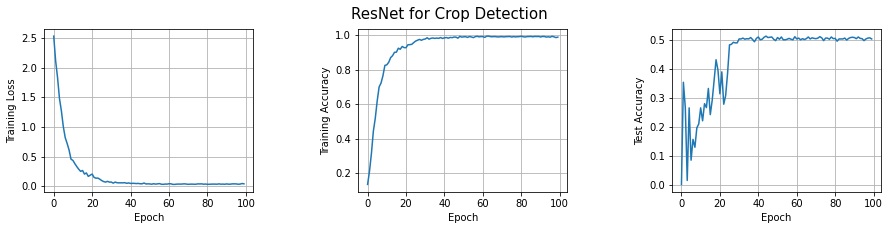

In [10]:
# Get a Clean Model for No Augmentation
model, criterion, optimizer, scheduler = getNetworkModel(step_size=step_size,gamma=gamma,optimizer_type=optimizer_type,scheduler_type=scheduler_type)

# Train the Network
model_trained, train_acc, train_loss, test_acc = train_model(model, criterion, optimizer,scheduler, num_epochs=epochs)

# Plot the Results
plotResults(train_loss, train_acc, test_acc,titleStr="ResNet for Crop Detection")

# Save Model
if do_save_model:
  torch.save(model_trained,path_to_saved_model+"model.pth")

Labels: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Predictions: [[1 1 0 0 0 1 1 6 0 1 0 3 1 0 0 3 3 0 0 1 0 0 1 1 1 0 1 1 1 0 3 1]]
Labels: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Predictions: [[1 0 0 1 1 0 0 1 1 0 1 1 1 1 1 0 0 3 0 1 0 1 1 1 1 0 0 1 3 1 1 3]]
Labels: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Predictions: [[0 1 0 3 1 0 1 1 0 0 0 0 1 1 3 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 0 3]]
Labels: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Predictions: [[1 0 0 0 1 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 0 0 1 3 0 1 3 1 1 0 1]]
Labels: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Predictions: [[1 1 0 1 0 1 1 0 0 1 1 0 0 0 1 0 1 3 0 1 0 0 1 1 0 1 1 0 0 1 1 0]]
Labels: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Predictions: [[0 0 1 1 3 0 0 1 1 0 3 3 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0 1 0 1 1 0]]
Labels: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

ValueError: ignored

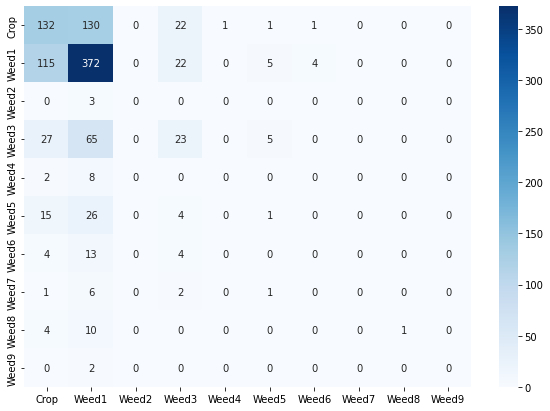

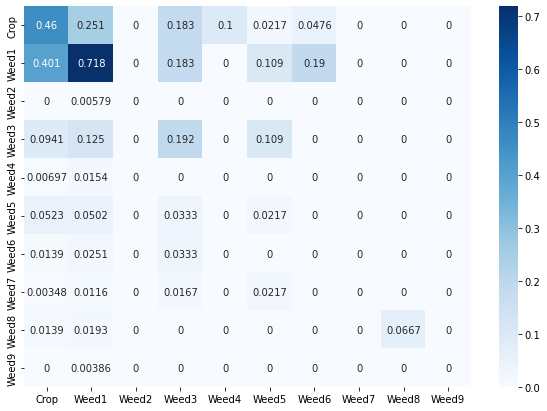

In [31]:
def getConfusionMatrix(model,dataloader,number_classes,verbose=True):
  """Calculates the Confusion Matrix for the given dataloader"""
  # https://stackoverflow.com/questions/53290306/confusion-matrix-and-test-accuracy-for-pytorch-transfer-learning-tutorial
  
  # Create a placeholder matrix
  confusion_matrix = torch.zeros(number_classes, number_classes)

  # Fill out the confusion Matrix
  y_label = np.array([])
  y_predict = np.array([])
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(dataloader):
          inputs = inputs.to(device)
          classes = classes.to(device)
          outputs = model(inputs)
          # Gets the predicted label
          _, preds = torch.max(outputs, 1)
          # np.vstack([ys, xs]) if ys.size else xs
          temp_labels = classes.view(1,-1).cpu().detach().numpy()
          temp_preds = preds.view(1,-1).cpu().detach().numpy()
          if verbose:
            print("Labels:",temp_labels)
            # print(temp_labels.shape)
            # print(y_label.size)
            print("Predictions:",temp_preds)
          y_label = np.hstack([y_label,temp_labels]) if y_label.size else temp_labels
          y_predict = np.hstack([y_predict,temp_preds]) if y_predict.size else temp_preds
          
          # Iterates through a zipped tuple and increments the confusion_matrix
          for t, p in zip(classes.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1
  
  confusion_matrix_percent = confusion_matrix/confusion_matrix.sum(1)

  # Print the array outputs
  if verbose:
    print(confusion_matrix)
    print(confusion_matrix_percent)
    print(confusion_matrix.diag()/confusion_matrix.sum(1))
    print("Y_labels",y_label.flatten())
    print("Y_predictions",y_predict.flatten())

  return confusion_matrix, confusion_matrix_percent, y_label, y_predict

def plotConfusionMatrix(confusion_matrix,labels=None):
  """Plots the Confusion Matrix and returns generated NumPy Array"""
  # Convert GPU Tensor to CPU Numpy Array
  confusion_matrix_np = confusion_matrix.cpu().detach().numpy()

  # Convert to Pandas Frame
  confusion_matrix_df = pd.DataFrame(
      confusion_matrix_np,
      index = labels,
      columns = labels)
  plt.figure(figsize = (10,7))
  sn.heatmap(confusion_matrix_df, annot=True,cmap='Blues', fmt='.3g')

  # Return the Numpy Array
  return confusion_matrix_np

# Reload the Model
if do_save_model:
  model_trained = torch.load(path_to_saved_model+"model.pth")
  model_trained.eval() # Convert to evaluation only, this is faster

# Determine the Confusion Matrix
conf_mat, conf_mat_pct, y_true, y_pred = getConfusionMatrix(model_trained,dataloaders['test'],len(labels))
plotConfusionMatrix(conf_mat,labels)
plotConfusionMatrix(conf_mat_pct,labels)

# Get Statistics
precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred)
print(precsision)
print(recall)
print(fscore)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Labels  Precision    Recall  F1 Score
0   Crop   0.440000  0.459930  0.449744
1  Weed1   0.585827  0.718147  0.645273
2  Weed2   0.000000  0.000000  0.000000
3  Weed3   0.298701  0.191667  0.233503
4  Weed4   0.000000  0.000000  0.000000
5  Weed5   0.076923  0.021739  0.033898
6  Weed6   0.000000  0.000000  0.000000
7  Weed7   0.000000  0.000000  0.000000
8  Weed8   1.000000  0.066667  0.125000
9  Weed9   0.000000  0.000000  0.000000
|    | Labels   |   Precision |    Recall |   F1 Score |
|---:|:---------|------------:|----------:|-----------:|
|  0 | Crop     |   0.44      | 0.45993   |  0.449744  |
|  1 | Weed1    |   0.585827  | 0.718147  |  0.645273  |
|  2 | Weed2    |   0         | 0         |  0         |
|  3 | Weed3    |   0.298701  | 0.191667  |  0.233503  |
|  4 | Weed4    |   0         | 0         |  0         |
|  5 | Weed5    |   0.0769231 | 0.0217391 |  0.0338983 |
|  6 | Weed6    |   0         | 0         |  0         |
|  7 | Weed7    |   0         | 0         |  0 

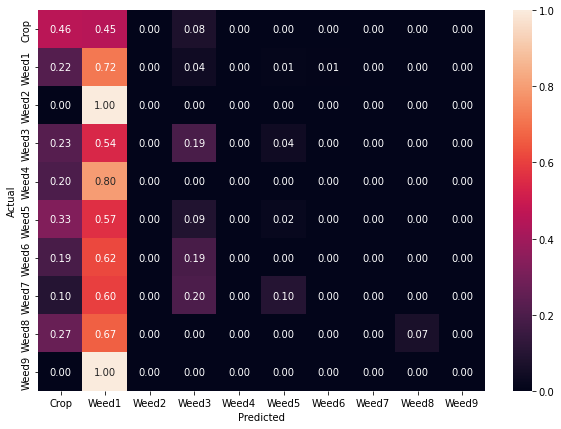

In [51]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
# https://stackoverflow.com/questions/31421413/how-to-compute-precision-recall-accuracy-and-f1-score-for-the-multiclass-case
# https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient
# https://stackoverflow.com/questions/20927368/how-to-normalize-a-confusion-matrix/66678924#66678924

# Calculate the Metrics
precision, recall, fscore, _ = precision_recall_fscore_support(y_true.reshape(-1), y_pred.reshape(-1),average=None)

# Bundle as a DataFrame
stats = {
    'Labels' : labels,
    'Precision' : precision,
    'Recall' : recall,
    'F1 Score' : fscore
}
df = pd.DataFrame(stats)
  
# Print the output.
print(df)
print(df.to_markdown()) 

cm = confusion_matrix(y_true.reshape(-1), y_pred.reshape(-1))
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,7))
sn.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)